# Few shot learning MAML

Celem dzisiejszych zajęć jest poznanie algorytmu MAML (Model Agnostic Meta Learning), a także zrozumienie teorii stojącej za few shot learningiem.

Aby intuicyjnie przyswoić ideę, zachęcamy do wykonania prostego zadania polegającego na dopasowania sampla (pierwszy obrazek), do odpowiedniej klasy (jeden obrazek z kilku poniżej) [tutaj](https://interactive-maml.github.io/) [1].

Zadanie w miarę proste, prawda? Otóż to czego właśnie dokonaliście bez żadnego namysłu, byłoby niesamowitym osiągnięciem dla modelu nauczania maszynowego.

Zazwyczaj uczymy model w jednym i konkretnym celu, na określonej liczbie klas i dużej ilości przykładów. Taki model niestety jest bezużyteczny do wykonywania innych zadań. 
Mózg za to, mając doświadczenie z podobnych zadań, potrafi nauczyć się nowego zadania czy klasy na znikomej liczbie przykładów. Taka możliwość jest bardzo korzystna, nie zawsze będziemy mieć tysiące dobrze zbalasowanych przykładów dla każdej klasy.

Co gdybyśmy próbowali naśladować ten schemat?
Taką próbę podejmuje właśnie MAML, czyli model-agnostic meta-learning. 

## Cel i wzory

(Uwaga: wszystkie wzory pochodzą z oryginalnej pracy [3])



Celem few-shot meta-learningu jest wytrenować model, który moze się szybko zaadaptować do nowego zadania używając tylko kilku przykładów i iteracji. Żeby to osiągnąć możemy traktować całe taski, jako przykłady treningowe, tak, aby nowy task był jak kolejny sample.

Rozważmy dystrybucję zadań $p(\mathcal T)$, do których chcemy, aby model się adaptował. W $K$-shot learningu model jest trenowany aby nauczył się nowego zadania $\mathcal T_i$ z $p(\mathcal T$) na podstawie tylko $K$ sampli i lossu $\mathcal L_{\mathcal T_i}$ wygenerowanego na zadaniu $T_i$. Model $f$ jest poprawiany biorąc pod uwagę jak zmienia się *test* error na nowych danych względem parametrów.
Mówiąc prościej, szukamy takich ogólnych parametrów modelu, które są czułe na zmiany w zadaniach tak, aby mała ich zmiana znacznie poprawiała wyniki na każdym z zadań wyciągniętych z $p(\mathcal T)$.

Mamy zatem funkcję $f_{\theta}$ z parametrami $\theta$. W trakcie adaptacji do nowego zadania $T_i$ parametry modelu $\theta$ stają się $\theta'$. Osiągane jest to za pomocą jednego lub więcej kroku gradientowego na zadaniu $T_i$:

$
\theta_{i}' = \theta - \alpha \nabla_{\theta} \mathcal L_{\mathcal T_i}(f_{\theta}),
$

gdzie $\alpha$ to wielkość kroku.

Parametry modelu są trenowane poprzez optymalizację $f_{\theta'}$ względem $\theta$ dla tasków z $p(\mathcal T)$. Meta-cel jest następujący:

$
\underset{\theta}{\mathrm{min}}\; \underset{\mathcal T_i \sim p(\mathcal T)}{\sum} \mathcal L_{\mathcal T_i}(f_{\theta'_i}) = \underset{\mathcal T_i \sim p(\mathcal T)}{\sum} \mathcal L_{\mathcal T_i}(f_{\theta - \alpha \nabla_{\theta} \mathcal L_{\mathcal T_i}(f_{\theta})})
$

Minimalizujemy $\theta$, tak, aby zsumowany koszt z wszystkich zadań, do których dostosowane były wagi $\theta'$, był jak najmniejszy.

Meta-optymalizacja jest dokonywana na parametrach modelu $\theta$, podczas gdy loss jest obliczany używając parametrów $\theta'$ specyficznych dla konretnego zadania. W efekcie celem jest uzyskanie takich parametrów, aby mała ich zmiana dawała dobre wyniki na różnych taskach. Parametry modelu zmieniane są przy pomocy SGD:

$
\theta \leftarrow \theta - \beta \nabla_{\theta} \underset{\mathcal T_i \sim p(\mathcal T)}{\sum} \mathcal L_{\mathcal T_i}(f_{\theta_i'})
$

gdzie $\beta$ to wielkość meta kroku. 

<img src="imgs/maml_quick_weights.png" alt="maml quick weights" width="500"/>

Celem jest otrzymanie takiego $\theta$, aby móc w małej liczbie kroków znaleźć $\theta'$ działające dobrze dla każdego z zadań.

<img src="imgs/MAML_training_diagram.png" alt="maml training diagram" width="900"/>

Źródło: [2]

Proces treningowy zatem polega na "kopiowaniu" uniwersalnych wag $\theta$, a następnie dotrenowaniu ich (czerwone strzałki - kroki gradientowe) pod specyficzne zadanie otrzymując $\theta_{i}'$. Następnie liczymy koszt wszystkich tasków $\mathcal L_i$, agregujemy i ulepszamy globalne parametry.

Adaptacja wag dla każdego zadania odbywa się na *support set* (czerwone strzałki), zaś ewaluacja odbywa się na *query set* (czarne strzałki). To odpowiedniki zbioru treningowego i testowego. 

## Logistyczna regresja przy użyciu MAML

Uwaga: poniższy kod jest mocno bazowany na [4]

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
import torch
import numpy as np
from torch import nn
import torch.nn.functional as F
from pylab import rcParams
from ipywidgets import interact


Naszym zadaniem będzie rozwiązanie problemu logistycznej regresji. Do wyznaczenia granicy decyzyjnej użyjemy zwykłej funkcji liniowej. Poniżej są funkcje, które posłużą do przygotowania danych do problemów o różnych parametrach. 

Tradycyjne podejście zapewniłoby dobre wyniki dla dow. ze stworzonych datasetów, jednak byłoby bezużyteczne, gdyby użyć tak stworzonego modelu na innym problemie.  

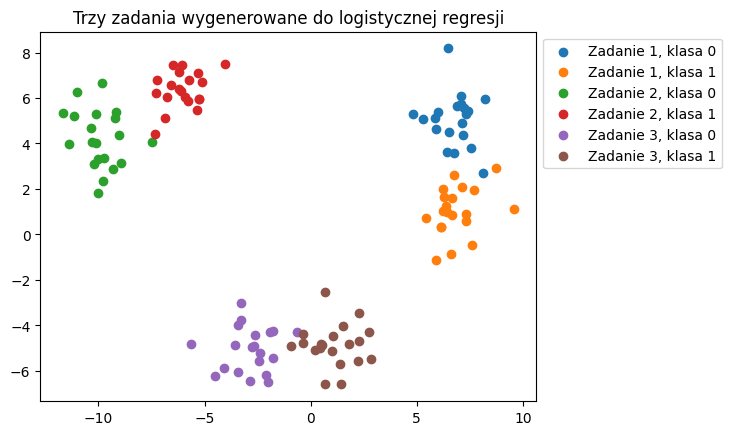

In [2]:
def generate_distribution(x_mean=0, x_std=1, y_mean=None, y_std=None, n_samples=100):
    """
    Generuje dwuwymiarowy rozkład Gaussa punktów.

    Parametry:
    - x_mean (float): Średnia wartość na osi x dla rozkładu.
    - x_std (float): Odchylenie standardowe wartości na osi x dla rozkładu.
    - y_mean (float lub None): Średnia wartość na osi y dla rozkładu.
        Jeśli None, przyjmuje wartość x_mean.
    - y_std (float lub None): Odchylenie standardowe wartości na osi y dla rozkładu.
        Jeśli None, przyjmuje wartość x_std.
    - n_samples (int): Liczba próbek do wygenerowania.

    Zwraca:
    - torch.Tensor: Tensor 2D reprezentujący wygenerowane punkty, gdzie każdy wiersz
        odpowiada jednej próbce, a kolumny reprezentują współrzędne x i y.
    """
    if y_mean is None:
        y_mean = x_mean
    if y_std is None:
        y_std = x_std

    x_mean = torch.tensor(x_mean).float()
    x_std = torch.tensor(x_std).float()
    y_mean = torch.tensor(y_mean).float()
    y_std = torch.tensor(y_std).float()

    X = torch.tensor([[
                    torch.normal(x_mean, x_std), 
                    torch.normal(y_mean, y_std)
                       ] 
                    for _ in range(n_samples)])
    return X

def sample_task_1(n_samples):
    """
    Tworzy dwa rozkłady o predefiniowanych parametrach i przydziela im klasę 0 i 1.
    """
    std = 1
    x_mean = 7
    y_mean = 5
    

    C0 = generate_distribution(x_mean, std, y_mean=y_mean, n_samples=n_samples)
    C1 = generate_distribution(x_mean, std, y_mean=y_mean-4, n_samples=n_samples)

    X = torch.cat((C0, C1))
    y = torch.cat((torch.zeros(n_samples), torch.ones(n_samples)))

    shuffler = np.random.permutation(len(X))

    return X[shuffler], y[shuffler]


def sample_task_2(n_samples):
    std = 1
    x_mean = -10
    y_mean = 4
    

    C0 = generate_distribution(x_mean, std, y_mean=y_mean, n_samples=n_samples)
    C1 = generate_distribution(x_mean+4, std, y_mean=y_mean+3, n_samples=n_samples)

    X = torch.cat((C0, C1))
    y = torch.cat((torch.zeros(n_samples), torch.ones(n_samples)))

    shuffler = np.random.permutation(len(X))

    return X[shuffler], y[shuffler]

def sample_task_3(n_samples):
    std = 1
    x_mean = -3
    y_mean = -5
    

    C0 = generate_distribution(x_mean, std, y_mean=y_mean, n_samples=n_samples)
    C1 = generate_distribution(x_mean+4, std, y_mean=y_mean, n_samples=n_samples)

    X = torch.cat((C0, C1))
    y = torch.cat((torch.zeros(n_samples), torch.ones(n_samples)))

    shuffler = np.random.permutation(len(X))

    return X[shuffler], y[shuffler]


n_samples = 20

tasks = [sample_task_1(n_samples), sample_task_2(n_samples), sample_task_3(n_samples)]

colors = [color["color"] for color in rcParams["axes.prop_cycle"]]
color_pairs = list(zip(colors[::2], colors[1::2]))

for i, task in enumerate(tasks):
    X, y = task
    class_0 = X[y == 0]
    class_1 = X[y == 1]
    
    plt.scatter(class_0[:,0], class_0[:,1], c=color_pairs[i][0], label=f"Zadanie {i+1}, klasa 0")
    plt.scatter(class_1[:,0], class_1[:,1], c=color_pairs[i][1], label=f"Zadanie {i+1}, klasa 1")


plt.legend(bbox_to_anchor=(1, 1))
plt.title("Trzy zadania wygenerowane do logistycznej regresji")
plt.show()

Mamy stworzone 3 zadania regresji logistycznej. Na pierwszy rzut oka widać, że nie da się ich rozwiązać wszystkich na raz jedną linią. Dopasowanie najlepszej linii do któregolwiek z tych zadań, będzie jednocześnie bezużyteczne dla innych. Liczymy na to, że użycie MAML pozwoli na wybranie linii, z której w kilka kroków będzie mogła powstać nowa dostosowana do *każdego* z tych zadań, a także przyszłych nowych zadań z tej kategorii.

Niżej funkcja do tworzenia sampli z losowego zadania, oraz do tworzenia support oraz query setów.

In [3]:
import random
def make_task(n, task_functions):
    """
    Tworzy sample z wylosowanego zadania z task_functions
    
    Parametry:
    - n (int): liczba sampli
    - tasks_functions (list): lista funkcji generujących taski

    Zwraca: 
    - X (array): koordynaty punktów
    - y (array): wartości klas
    """
    task = random.choice(task_functions)
    X, y = task(n)
    return X, y
    

def split_support_query(X, y):
    """
    Dokonuje podziału danych na support i query set.

    Parametry:
    - X (array): koordynaty punktów.
    - y (array): wartości klas.

    Zwraca:
    - X_support (array): koordynaty punktów w zbiorze support.
    - y_support (array): wartości klas w zbiorze support.
    - X_query (array): koordynaty punktów w zbiorze query.
    - y_query (array): wartości klas w zbiorze query.
    """
    ones = np.where(y == 1)[0]

    threshold = ones.size // 2

    support_ind_ones = ones[:threshold]
    query_ind_ones = ones[threshold:]

    zeros = np.where(y == 0)[0]

    threshold = zeros.size // 2

    support_ind_zeros = zeros[:threshold]
    query_ind_zeros = zeros[threshold:]

    support_indices = np.concatenate((support_ind_ones, support_ind_zeros), axis=0)
    query_indices = np.concatenate((query_ind_ones, query_ind_zeros), axis=0)

    return X[support_indices], y[support_indices], X[query_indices], y[query_indices]

In [4]:
def get_vector(model):
    """
    Zwraca uniwersalne wagi modelu
    """
    A = model.weight[0][0].detach().numpy()
    B = model.weight[0][1].detach().numpy()
    C = model.bias[0].detach().numpy()
    return A, B, C

def get_fast_vector(model):
    """
    Zwraca adaptowane wagi modelu
    """
    A = model.weight.fast[0][0].detach().numpy()
    B = model.weight.fast[0][1].detach().numpy()
    C = model.bias.fast[0].detach().numpy()
    return A, B, C

In [5]:
class MAML(nn.Module):
    def __init__(self, n_task, n_gradient_steps, alpha_lr):
        super(MAML, self).__init__()
        """
        Parametry:
        - n_task (int): Liczba zadań (tasków), po której będzie sumowany ich koszt oraz nastąpi aktualizacja wag uniwersalnych
        - n_gradient_steps (int): Liczba kroków gradientowych używanych do dostosowywania wag w trakcie trenowania pod pojedyncze zadanie.
        - alpha_lr (float): Wartość współczynnika uczenia używanego do aktualizacji wag w trakcie dostosowywania.

        Atrybuty:
        - loss_fn: Funkcja straty używana w trakcie trenowania.
        - weight: Parametr modelu reprezentujący wagi uniwersalne.
        - bias: Parametr modelu reprezentujący obciążenie uniwersalne.
        - n_gradient_steps: Liczba kroków gradientowych.
        - n_task: Liczba zadań (tasków), po której będzie sumowany ich koszt oraz nastąpi aktualizacja wag uniwersalnych
        - alpha_lr: Wartość współczynnika uczenia używana do aktualizacji wag w trakcie dostosowywania.
        - fast_params_list: Lista przechowująca wektory wag w kolejnych krokach
        """

        self.loss_fn = nn.BCELoss()

        # Dla prostoty i czytelności późniejszego kodu inicjalizuję wagi i bias w samym modelu MAML
        # w rzeczywistości można tu podpiąć dow. inny model np.
        # self.classifier = LogisticRegression()
        # W datasecie mamy punkty o dwóch współrzędnych, wedle których chcemy wyznaczyć granicę klas
        # Potrzebne są zatem tylko 2 wagi i bias
        # Ax + By + C
        self.weight = nn.Parameter(torch.randn(1, 2))
        self.bias = nn.Parameter(torch.randn(1))
        
        # Zostawiamy wolne miejsce na przechowywanie nowych wag specyficznych pod task
        self.weight.fast = None
        self.bias.fast = None
        self.fast_params_list = []


        self.n_gradient_steps = n_gradient_steps
        
        self.n_task = n_task
        
        # 0' = 0 - alpha_lr * grad_0 L_Ti(f0)
        self.alpha_lr = alpha_lr


    def forward(self, x):
        if self.weight.fast is not None and self.bias.fast is not None:
            out = x.matmul(self.weight.fast.t()) + self.bias.fast  # stosowanie zaadaptowanych wag 0'
        else:
            out = x.matmul(self.weight.t()) + self.bias # stosowanie uniwersalnych wag 0, jeśli to pierwszy krok 
        out = torch.sigmoid(out)
        return out

    def adapt_theta(self, X_support, y_support, X_query, y_query):
        """
        Dostosowanie wag dla pojedynczego zadania
        """
        
        # Inicjalizacja zmiennych używanych do obliczania nowego 0'
        self.fast_params_list.clear()
        fast_parameters = list(self.parameters())
        for weight in self.parameters():
            weight.fast = None


        self.zero_grad()
        accuracies = []

        # Tutaj wykonujemy przesuwanie wag theta w n krokach w najlepszym kierunku dla otrzymanego zadania.
        for gradient_step in range(self.n_gradient_steps):


            # Trening wykonujemy na support secie
            scores = self.forward(X_support)
            set_loss = self.loss_fn( scores, y_support.unsqueeze(1))


            # Dlaczego używamy create_graph=True?
            # W MAML modyfikujemy nasz model w trakcie trenowania, 
            # a następnie używamy tych zmienionych wag do obliczenia nowych gradientów w zewnętrznej pętli.
            # zwykłe backward() oblicza tylko pierwsze pochodne (gradienty), ale nam potrzebne są drugie pochodne (drugiego rzędu).
            # Musimy móc się "cofnąć", żeby zaktualizować uniwersalne parametry modelu
            # dzięki create_graph=True możemy obliczyć gradienty dla gradientów
            
            grad = torch.autograd.grad(set_loss, fast_parameters, create_graph=True) 
            
            
            fast_parameters = []

            
            for k, weight in enumerate(self.parameters()):
                # Jeśli to jest pierwszy krok, to startujemy z wag uniwersalnych
                # potem używamy wag z poprzedniego kroku
                if weight.fast is None:
                    weight.fast = weight - self.alpha_lr * grad[k] 
                else:
                    weight.fast = weight.fast - self.alpha_lr * grad[k] 
                fast_parameters.append(weight.fast)
            
            # przechowujemy wagi z każdego kroku
            self.fast_params_list.append(get_fast_vector(self))


            query_scores = self.forward(X_query)
            predictions  = (query_scores > 0.5).squeeze()
            correct_predictions = (predictions == y_query).float()
            accuracies.append((correct_predictions.sum() / predictions.size()[0]).item() * 100)

        return accuracies

    def calculate_adapted_theta_loss(self, X_support, y_support, X_query, y_query):
        """
        Oblicza loss wag 0' dostosowanych do zadania
        """
        accuracies = self.adapt_theta(X_support, y_support, X_query, y_query)
        
        # teraz model jest po adaptacji, forward będzie zatem na nowych wagach (.fast is not None)
        final_scores = self.forward(X_query)
        
        y_query = y_query.unsqueeze(1)
        loss = self.loss_fn(final_scores, y_query)

        predictions  = (final_scores > 0.5)
        correct_predictions = (predictions == y_query)
        task_accuracy = (correct_predictions.sum() / predictions.size()[0]) * 100

        return loss, accuracies + [task_accuracy], correct_predictions.squeeze()

In [6]:
def get_line_params(scale, A, B, C):
    """
    Funkcja obliczająca wartości prostej opisującej granicę decyzyjną.

    Parametry:
    - scale: Skalowanie
    - A, B, C: Parametry równania prostej Ax + By + C = 0.

    Ax + By + C = 0 | - By
    By = -(Ax + C) | /B 
    y = (-A/B)x - (C/B)

    Zwraca:
    - x_arg: Wartości x na osi X.
    - dx: Przesunięcie na osi x.
    - dy: Przesunięcie na osi y.
    - y: Wartości y obliczone na podstawie równania prostej.
    """
    x_step = np.absolute(B) * (15 / np.sqrt((np.power(A, 2) + np.power(B, 2))))
    x = np.arange(-x_step, x_step + 0.1, 0.1)
    y = (-A/B)*x-(C/B)

    arr_length = np.sqrt(np.power(A, 2) + np.power(B, 2))

    dx = scale*A/arr_length
    dy = scale*B/arr_length

    return x, y, dx, dy

def plot_maml_boundaries(model, X, y, plot_decision_boundary=True, plot_adaptation_arrows=True):
    """
    Rysuje granice decyzyjne modelu MAML dla podanego zadania
    Niebieska linia - wagi uniwersalne
    Czerwone linie - wagi adaptowane w danej liczbie kroków
    Czerwone strzałki - kierunek zmian
    
    Parametry:
    - model: model MAML
    - X (array): koordynaty punktów
    - y (array): klasy punktów
    """

    A, B, C = get_vector(model)

    figs, axs = plt.subplots(1,1, figsize=(7, 7))
    
    class_0 = X[y == 0]
    class_1 = X[y == 1]
    plt.scatter(class_0[:, 0], class_0[:, 1], c='yellow', label='Klasa 0')
    plt.scatter(class_1[:, 0], class_1[:, 1], c='purple', label='Klasa 1')
    
    axs.set_xlim([-20,20])
    axs.set_ylim([-20,20])

    if plot_decision_boundary:    
        scale = 3

        x, y, dx, dy = get_line_params(scale, A, B, C)

        adaptation_arr_start_coords_1 = (x[0], y[0])
        adaptation_arr_start_coords_2 = (x[-1], y[-1])

        # przechodzimy po wcześniej zapisanych przechodnich wagach
        for i_grad_step, adapted_theta in enumerate(model.fast_params_list, 1):
            A_fast, B_fast, C_fast = adapted_theta

            x_fast, y_fast, dx_fast, dy_fast = get_line_params(scale, A_fast, B_fast, C_fast)

            # im bliżej finalnych parametrów, tym intensywniejszy kolor granicy
            alpha = 0.1 * i_grad_step if i_grad_step < model.n_gradient_steps else 1

            head_length=0.6
            head_width=0.6

            if plot_adaptation_arrows:
                arr1_dx = -adaptation_arr_start_coords_1[0] + x_fast[0]
                arr1_dy = -adaptation_arr_start_coords_1[1] + y_fast[0]

                arr2_dx = -adaptation_arr_start_coords_2[0] + x_fast[-1]
                arr2_dy = -adaptation_arr_start_coords_2[1] + y_fast[-1]

                plt.arrow(adaptation_arr_start_coords_1[0], adaptation_arr_start_coords_1[1], arr1_dx, arr1_dy, head_width=head_width, head_length=head_length, fc='#cc0000', ec='#cc0000', alpha=alpha)
                plt.arrow(adaptation_arr_start_coords_2[0], adaptation_arr_start_coords_2[1], arr2_dx, arr2_dy, head_width=head_width, head_length=head_length, fc='#cc0000', ec='#cc0000', alpha=alpha)

                adaptation_arr_start_coords_1 = (x_fast[0], y_fast[0])
                adaptation_arr_start_coords_2 = (x_fast[-1], y_fast[-1])
            plt.arrow(0, -(C_fast/B_fast), dx_fast, dy_fast, head_width=0.7, head_length=0.7, fc='#cc0000', ec='#cc0000', alpha=alpha)

            if i_grad_step == len(model.fast_params_list):
                plt.plot(x_fast, y_fast, c='#ff4d4d', alpha=alpha, label="Zaadaptowane wagi")
            else:
                plt.plot(x_fast, y_fast, c='#ff4d4d', alpha=alpha, label="_nolegend_")
        

        plt.arrow(0, -(C/B), dx, dy, head_width=0.7, head_length=0.7, fc='#0000b3', ec='#0000b3')
        plt.plot(x, y, c='#4d4dff', label='Uniwersalne wagi')

    plt.title("Granice decyzyjne modelu")
    plt.grid()
    plt.legend(loc='upper right')
    plt.show()

W trakcie procesu trenowania będziemy wizualizować postęp. Niebieska linia przedstawia wagi uniwersalne. Czerwone linie to kolejne kroki (n_gradient_steps) adaptacji modelu. Strzałki wskazują kierunek zmian. 

In [7]:
def train(model, epochs, task_functions, optimizer, n_samples=20, print_freq=500, enable_plotting=True):
    """
    Trenuje model przy użyciu MAML
    Dla liczby epok:
        1. Wylosuj zadanie
        2. Zaadaptuj theta
        3. Oblicz i zapisz loss
        4. Gdy uzbiera się ustalona liczba zadań
            a) sumowanie lossu wszystkich zadań
            b) aktualizacja wag uniwersalnych
    """
    task_count = 0
    avg_loss = 0
    loss_all = []
    acc_all = []
    optimizer.zero_grad()

    for i in range(epochs):
        X, y = make_task(n_samples, task_functions)

        X_support, y_support, X_query, y_query = split_support_query(X, y)
        loss, task_accuracy, positions = model.calculate_adapted_theta_loss(X_support, y_support, X_query, y_query)
        task_accuracy = task_accuracy[-1]
        avg_loss = avg_loss + loss.item()
        loss_all.append(loss)
        acc_all.append(task_accuracy)

        task_count += 1


        if task_count == model.n_task:  
            loss_q = torch.stack(loss_all).sum(0)
            loss_q.backward()

            optimizer.step()
            task_count = 0
            loss_all = []

        optimizer.zero_grad()

        if i % print_freq == 0:
            acc_all_np = np.asarray(acc_all)
            acc_mean = np.mean(acc_all_np)
            print('Epoch {:d} | Loss {:f} | Acc {:4.2f}% | Task Acc {:4.2f}%'.format(i, avg_loss/float(i+1), acc_mean, task_accuracy))

        if enable_plotting and i % print_freq == 0:
            plot_maml_boundaries(model, X, y)

In [8]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

epochs = 10000
alpha_lr = 1e-1 # dla kroków gradientowych
beta_lr = 1e-3 # dla wag uniwersalnych modelu
n_gradient_steps = 2 # ile mamy kroków na adaptację do nowego zadania
model = MAML(n_gradient_steps = n_gradient_steps, n_task = 4, alpha_lr = alpha_lr)
optimizer = torch.optim.Adam(model.parameters(), lr=beta_lr)
task_functions = [sample_task_1, sample_task_2, sample_task_3]
model 

MAML(
  (loss_fn): BCELoss()
)

Epoch 0 | Loss 0.417591 | Acc 75.00% | Task Acc 75.00%


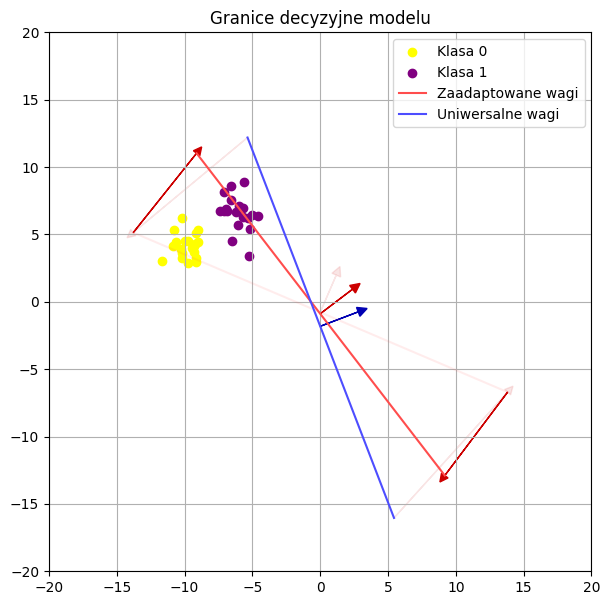

Epoch 500 | Loss 0.415019 | Acc 84.76% | Task Acc 65.00%


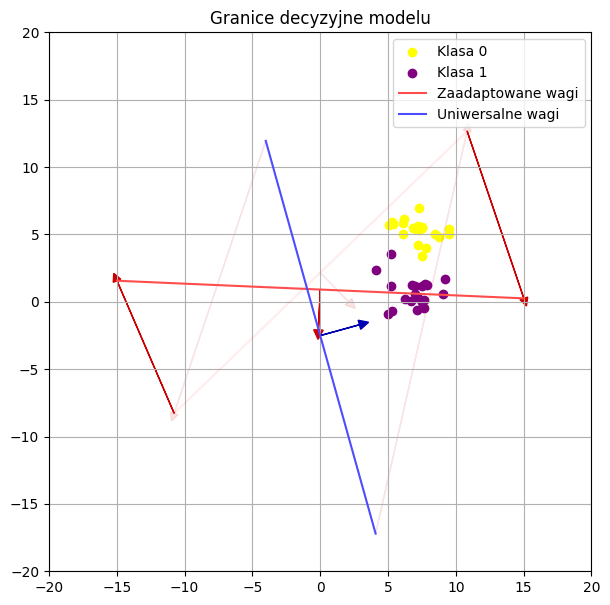

Epoch 1000 | Loss 0.389001 | Acc 86.61% | Task Acc 70.00%


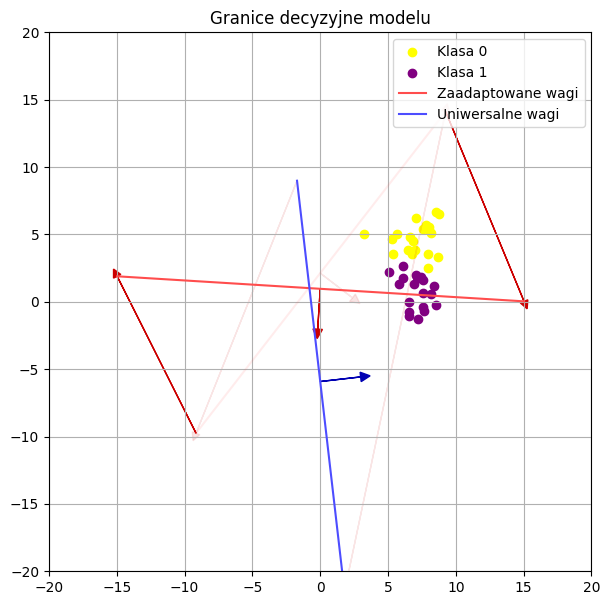

Epoch 1500 | Loss 0.366295 | Acc 88.98% | Task Acc 100.00%


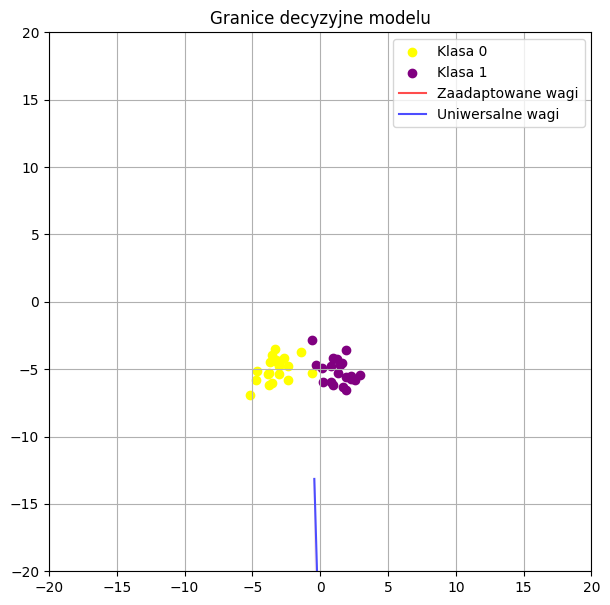

Epoch 2000 | Loss 0.347146 | Acc 90.94% | Task Acc 100.00%


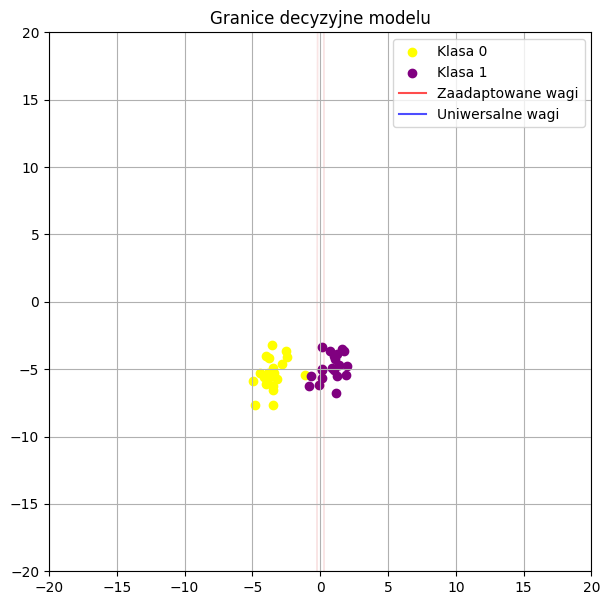

Epoch 2500 | Loss 0.332842 | Acc 92.19% | Task Acc 100.00%


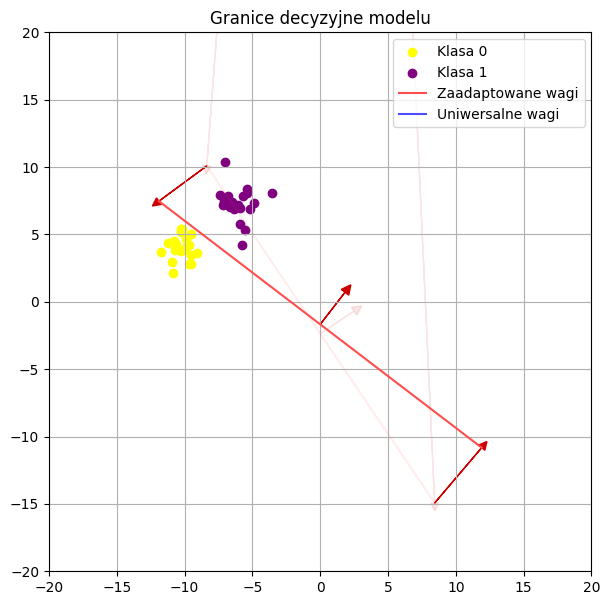

Epoch 3000 | Loss 0.323521 | Acc 92.81% | Task Acc 95.00%


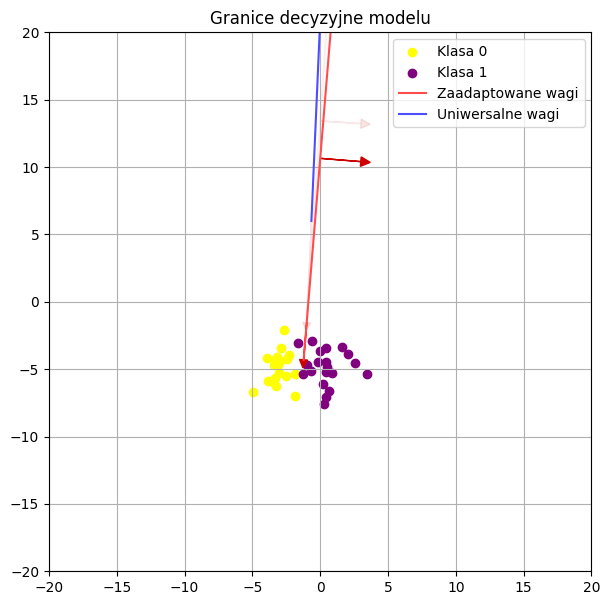

Epoch 3500 | Loss 0.315753 | Acc 93.24% | Task Acc 100.00%


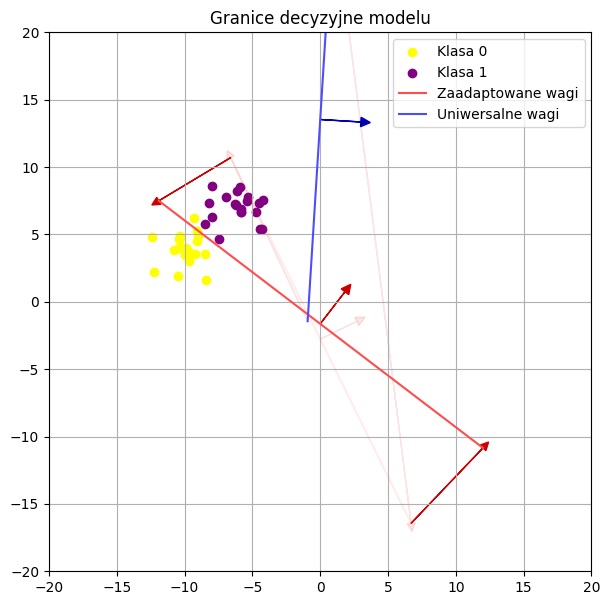

Epoch 4000 | Loss 0.308792 | Acc 93.51% | Task Acc 90.00%


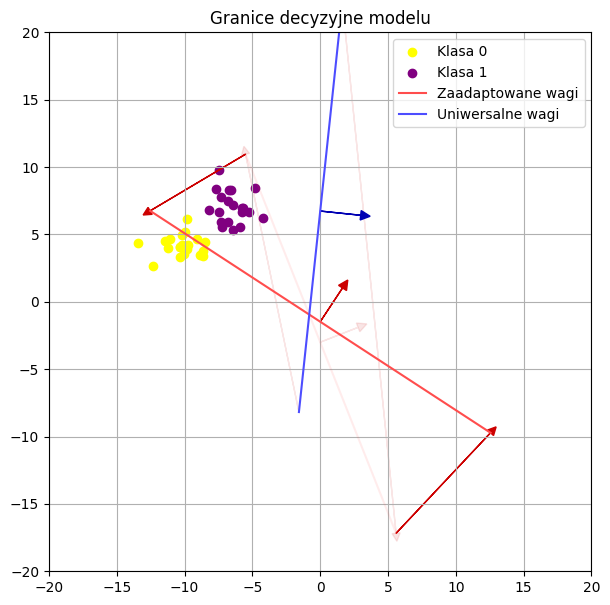

Epoch 4500 | Loss 0.302319 | Acc 93.74% | Task Acc 100.00%


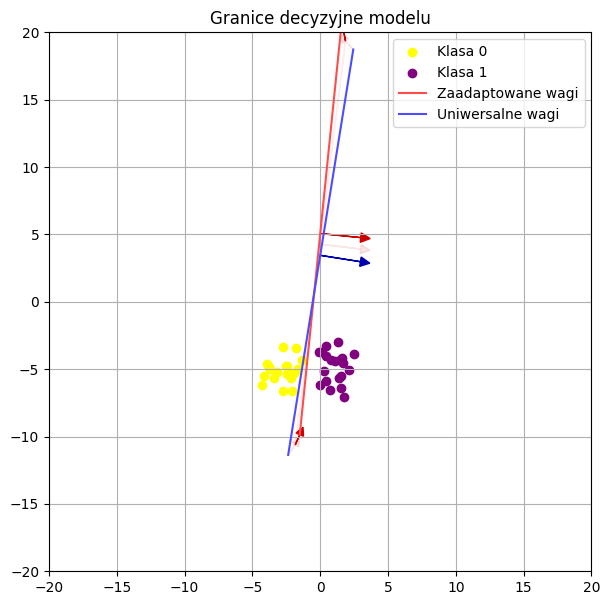

Epoch 5000 | Loss 0.296336 | Acc 93.95% | Task Acc 85.00%


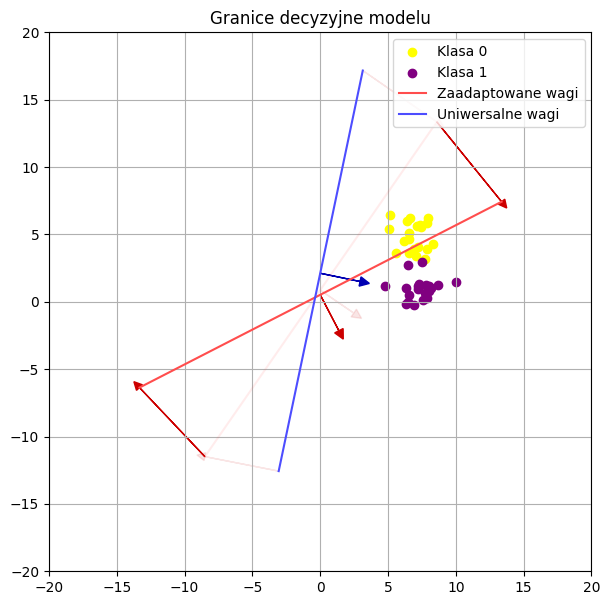

Epoch 5500 | Loss 0.290662 | Acc 94.17% | Task Acc 95.00%


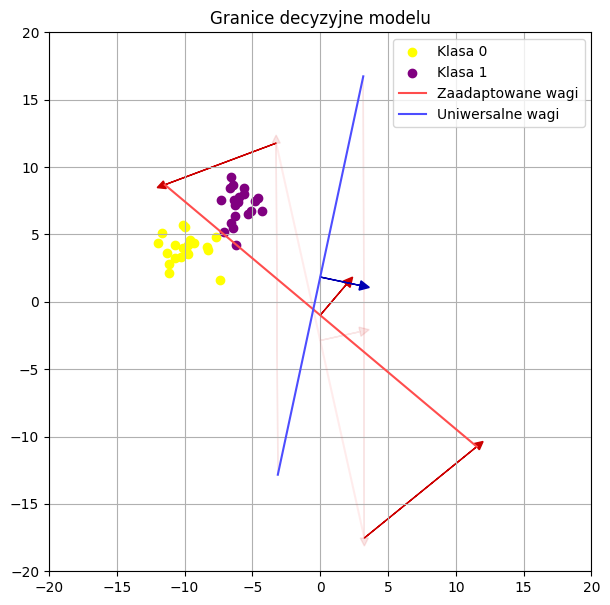

Epoch 6000 | Loss 0.286264 | Acc 94.33% | Task Acc 70.00%


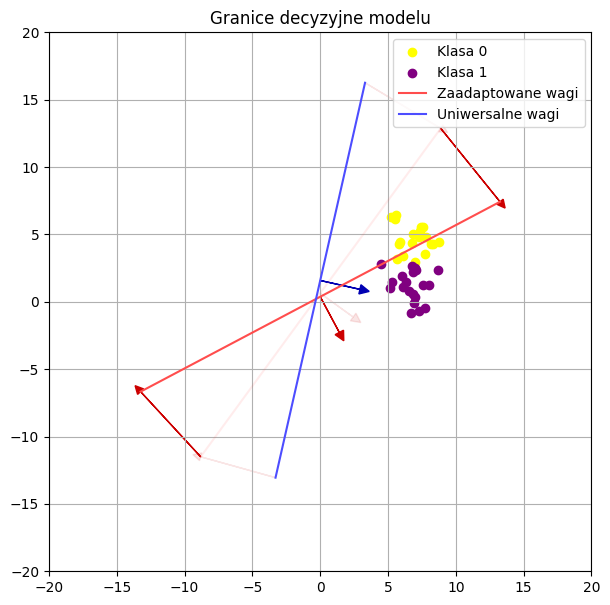

Epoch 6500 | Loss 0.282950 | Acc 94.48% | Task Acc 100.00%


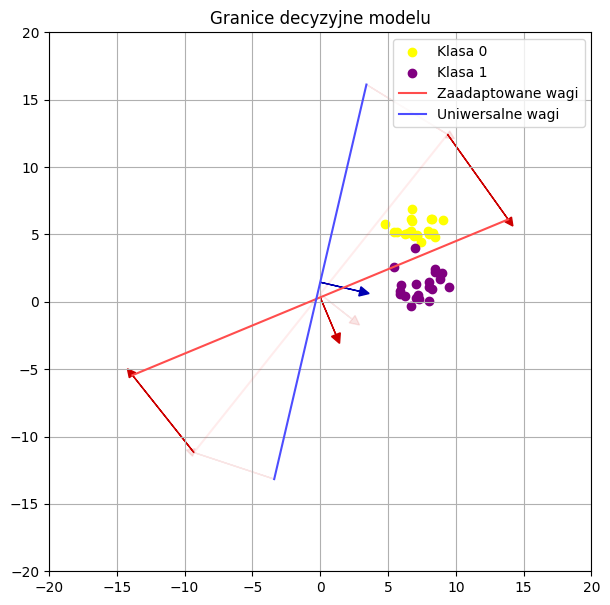

Epoch 7000 | Loss 0.279947 | Acc 94.60% | Task Acc 100.00%


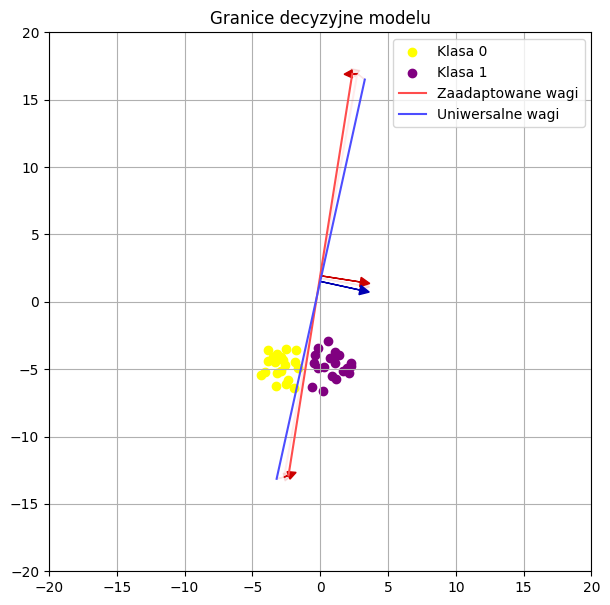

Epoch 7500 | Loss 0.277203 | Acc 94.73% | Task Acc 90.00%


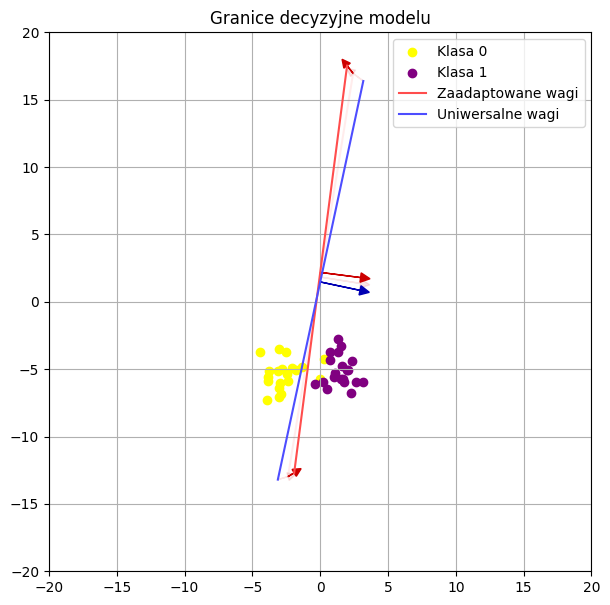

Epoch 8000 | Loss 0.275050 | Acc 94.82% | Task Acc 100.00%


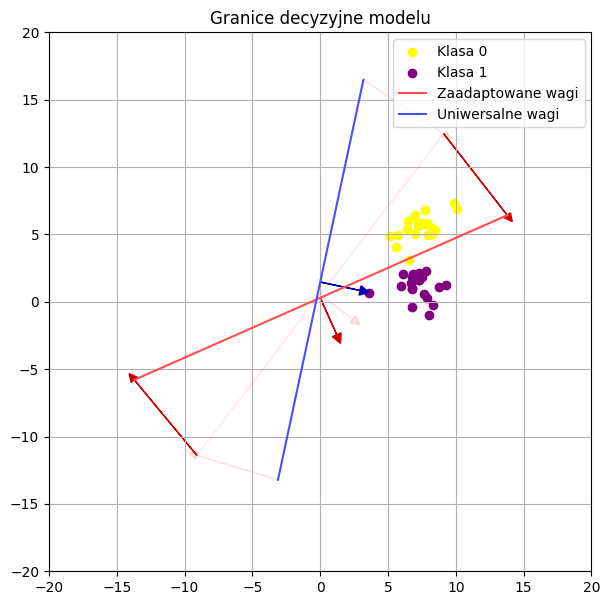

Epoch 8500 | Loss 0.272872 | Acc 94.91% | Task Acc 95.00%


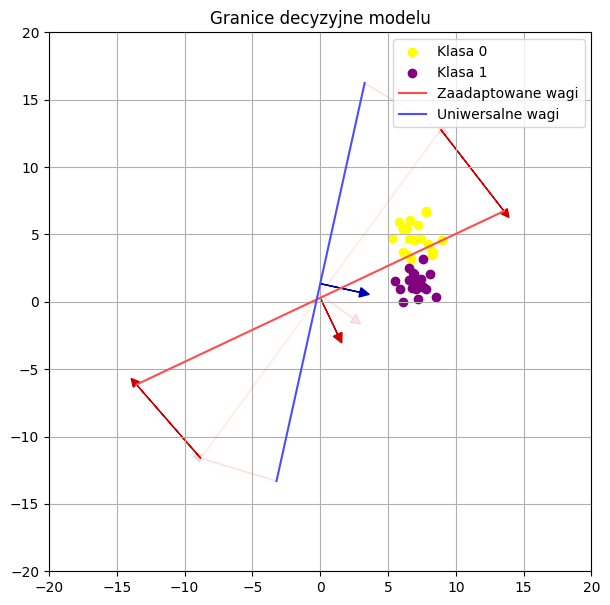

Epoch 9000 | Loss 0.271202 | Acc 94.98% | Task Acc 100.00%


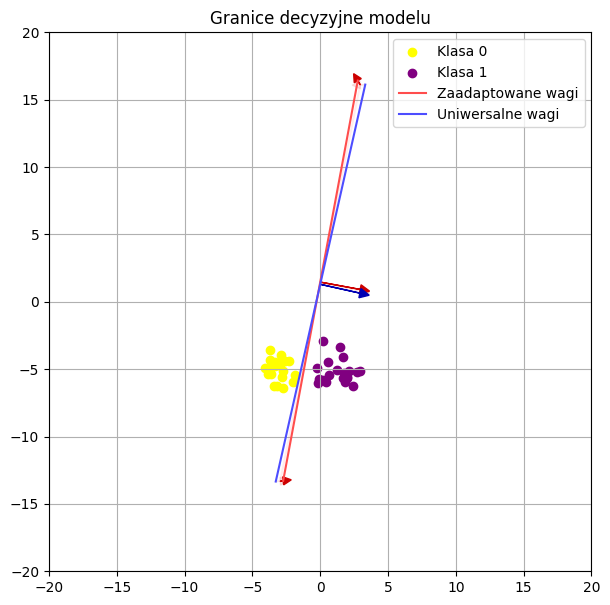

Epoch 9500 | Loss 0.269357 | Acc 95.07% | Task Acc 100.00%


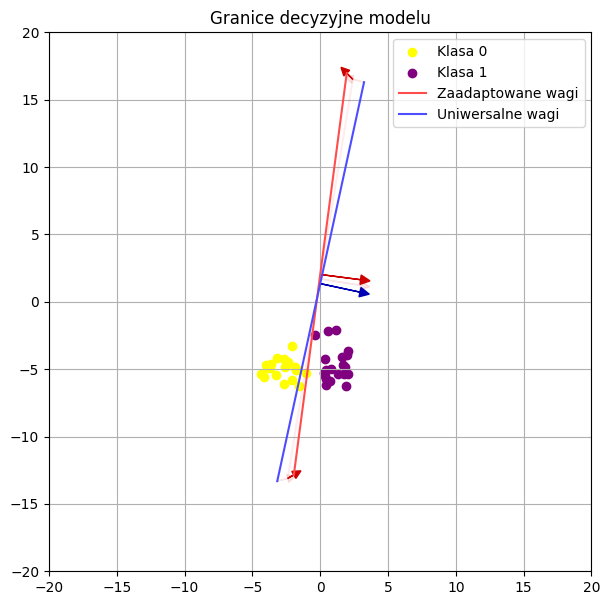

In [9]:
train(model, epochs, task_functions, optimizer)

In [10]:
def plot_maml_boundaries_all_tasks(model, tasks_to_display, task_to_adapt, plot_decision_boundary=True, plot_adaptation_arrows=True):
    """
    Rysuje granice decyzyjne modelu MAML dla podanego zadania, oraz wyświetla podane zbiory
    Niebieska linia - wagi uniwersalne
    Czerwone linie - wagi adaptowane w danej liczbie kroków
    Czerwone strzałki - kierunek zmian
    
    Parametry:
    - model: model MAML
    - tasks_to_display (list): lista krotek postaci (X, y), gdzie X to koordynaty punktów, y to klasy punktów
    - task_to_adapt (tuple): krotka postaci (X, y), gdzie X to koordynaty punktów, y to klasy punktów. 
        Do tego tasku będzie dopasowywał się model
    """

    A, B, C = get_vector(model)

    figs, axs = plt.subplots(1,1, figsize=(7, 7))
    
    for task in tasks_to_display:
        plt.scatter(task[0][:,0], task[0][:,1], c=task[1])
    
    X, y = task_to_adapt
    
    class_0 = X[y == 0]
    class_1 = X[y == 1]
    plt.scatter(class_0[:,0], class_0[:,1], c="cyan", label="Klasa 0")
    plt.scatter(class_1[:,0], class_1[:,1], c="fuchsia", label="Klasa 1")
    
    axs.set_xlim([-20,20])
    axs.set_ylim([-20,20])

    if plot_decision_boundary:    
        scale = 3

        x, y, dx, dy = get_line_params(scale, A, B, C)

        adaptation_arr_start_coords_1 = (x[0], y[0])
        adaptation_arr_start_coords_2 = (x[-1], y[-1])

        # przechodzimy po wcześniej zapisanych przechodnich wagach
        for i_grad_step, adapted_theta in enumerate(model.fast_params_list, 1):
            A_fast, B_fast, C_fast = adapted_theta

            x_fast, y_fast, dx_fast, dy_fast = get_line_params(scale, A_fast, B_fast, C_fast)

            # im bliżej finalnych parametrów, tym intensywniejszy kolor granicy
            alpha = 0.1 * i_grad_step if i_grad_step < model.n_gradient_steps else 1

            head_length=0.6
            head_width=0.6

            if plot_adaptation_arrows:
                arr1_dx = -adaptation_arr_start_coords_1[0] + x_fast[0]
                arr1_dy = -adaptation_arr_start_coords_1[1] + y_fast[0]

                arr2_dx = -adaptation_arr_start_coords_2[0] + x_fast[-1]
                arr2_dy = -adaptation_arr_start_coords_2[1] + y_fast[-1]

                plt.arrow(adaptation_arr_start_coords_1[0], adaptation_arr_start_coords_1[1], arr1_dx, arr1_dy, head_width=head_width, head_length=head_length, fc='#cc0000', ec='#cc0000', alpha=alpha)
                plt.arrow(adaptation_arr_start_coords_2[0], adaptation_arr_start_coords_2[1], arr2_dx, arr2_dy, head_width=head_width, head_length=head_length, fc='#cc0000', ec='#cc0000', alpha=alpha)

                adaptation_arr_start_coords_1 = (x_fast[0], y_fast[0])
                adaptation_arr_start_coords_2 = (x_fast[-1], y_fast[-1])
            
            plt.arrow(0, -(C_fast/B_fast), dx_fast, dy_fast, head_width=0.7, head_length=0.7, fc='#cc0000', ec='#cc0000', alpha=alpha)
            
            if i_grad_step == len(model.fast_params_list):
                plt.plot(x_fast, y_fast, c='#ff4d4d', alpha=alpha, label="Zaadaptowane wagi")
            else:
                plt.plot(x_fast, y_fast, c='#ff4d4d', alpha=alpha, label="_nolegend_")

        plt.arrow(0, -(C/B), dx, dy, head_width=0.7, head_length=0.7, fc='#0000b3', ec='#0000b3')
        plt.plot(x, y, c='#4d4dff', label="Uniwersalne wagi")
    plt.legend(bbox_to_anchor=(1, 1))
    plt.title("Granica decyzyjna zaadaptowana do nowego zadania")
    plt.grid()
    plt.show()

# Zadanie 1 (punktowane)
Poniżej znajduje się narzędzie do analizy wytrenowanego wcześniej modelu. Na plocie przedstawione są 3 zadania, które model widział i na których się uczył. 

Widnieje też czwarte, nowe zadanie. Przy użyciu suwaków można zmieniać wartości średniej rozkładu oraz odchylenia standardowego rozkładu obu nowych klas (niebieskiej i różowej). 

Przeanalizuj działanie modelu i zapisz obserwacje oraz wnioski.

In [11]:
n_samples = 20
precomputed_tasks = [task(n_samples) for task in task_functions]

def series(blue_x_mean=0, blue_y_mean=0, blue_x_std=1, blue_y_std=1, pink_x_mean=0, pink_y_mean=0, pink_x_std=1, pink_y_std=1):
    C0 = generate_distribution(blue_x_mean, blue_x_std, blue_y_mean, blue_y_std, n_samples=n_samples)
    C1 = generate_distribution(pink_x_mean, pink_x_std, pink_y_mean, pink_y_std, n_samples=n_samples)

    new_X = torch.cat((C0, C1))
    new_y = torch.cat((torch.zeros(n_samples), torch.ones(n_samples)))
    
    X_support, y_support, X_query, y_query = split_support_query(new_X, new_y)
    model.adapt_theta(X_support, y_support, X_query, y_query)
    
    plot_maml_boundaries_all_tasks(model, precomputed_tasks, (new_X, new_y))
    final_scores = model.forward(X_query)
    y_query = y_query.unsqueeze(1)

    predictions  = (final_scores > 0.5)
    correct_predictions = (predictions == y_query)
    task_accuracy = (correct_predictions.sum() / predictions.size()[0]) * 100
    print(f"Accuracy {task_accuracy.item()}%")
    return


interact(series, blue_x_mean=(-15,15,0.1), blue_y_mean=(-15,15,0.1), blue_x_std=(0,10,0.1),blue_y_std=(0,10,0.1), pink_x_mean=(-15,15,0.1), pink_y_mean=(-15,15,0.1), pink_x_std=(0,10,0.1), pink_y_std=(0,10,0.1));

interactive(children=(FloatSlider(value=0.0, description='blue_x_mean', max=15.0, min=-15.0), FloatSlider(valu…

### Wnioski i obserwacje

Uniwersalne wagi (niebieska linia), dobrze separują jedno z zadań. Jak już zauważyliśmy na początku, nie da się rozstrzygnąć wszystkich tasków jednocześnie przy pomocy jednej prostej, zatem model musiał wybrać, gdzie poprowadzić granicę decyzyjną. Ustawił granicę w okolicy ostatnio widzianego tasku w fazie treningu, która dobrze go rozwiązuje.

Granica decyzyjna dostowuje się najlepiej, jeśli nowe klasy przemieszczamy w pobliże wcześniej widzianych rozkładów, zatem model dostosował się do nich odpowiednio. Kiedy prezentowany jest rozkład niewidziany wcześniej, granica wciąż jest poprawna i gwarantuje wysokie accuracy. Jest to zachowanie oczekiwane, chcieliśmy aby sieć dobrze generalizowała i potrafiła poprawnie odpowiadać na nowe przykłady zadań.

Możliwe jest znalezienie takich rozkładów (nawet seperowalnych liniowo), w których model zawodzi. Może to być wynikiem zbyt niskiej liczby kroków gradientowych, zbyt krótkiego treningu albo nie najoptymalniejszego rozłożenia tasków treningowych.

Próbą rozwiązania tego problemu byłoby zwiększenie liczby kroków, wydłużenie treningu, dodanie/zróżnicowanie zadań.

# Zadanie 2

Wytrenuj model_2 z pominięciem jednego z zadań, a następnie z użyciem narzędzia interaktywnego przeanalizuj model i zapisz obserwacje oraz wnioski.

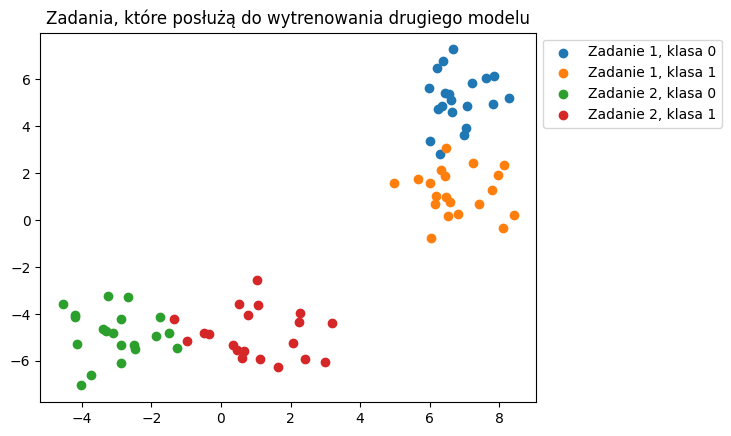

In [13]:
# Tu wybierz, z którego zadania zrezygnować
task_functions = [sample_task_1, sample_task_3]

colors = [color["color"] for color in rcParams["axes.prop_cycle"]]
color_pairs = list(zip(colors[::2], colors[1::2]))

for i, task_func in enumerate(task_functions):
    X, y = task_func(n_samples)
    class_0 = X[y == 0]
    class_1 = X[y == 1]
    
    plt.scatter(class_0[:,0], class_0[:,1], c=color_pairs[i][0], label=f"Zadanie {i+1}, klasa 0")
    plt.scatter(class_1[:,0], class_1[:,1], c=color_pairs[i][1], label=f"Zadanie {i+1}, klasa 1")


plt.legend(bbox_to_anchor=(1, 1))
plt.title("Zadania, które posłużą do wytrenowania drugiego modelu")
plt.show()

Epoch 0 | Loss 0.511079 | Acc 90.00% | Task Acc 90.00%


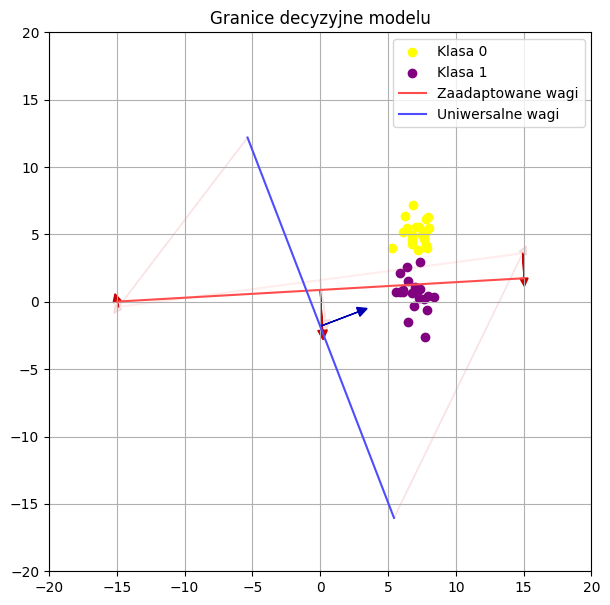

Epoch 500 | Loss 0.450599 | Acc 91.39% | Task Acc 85.00%


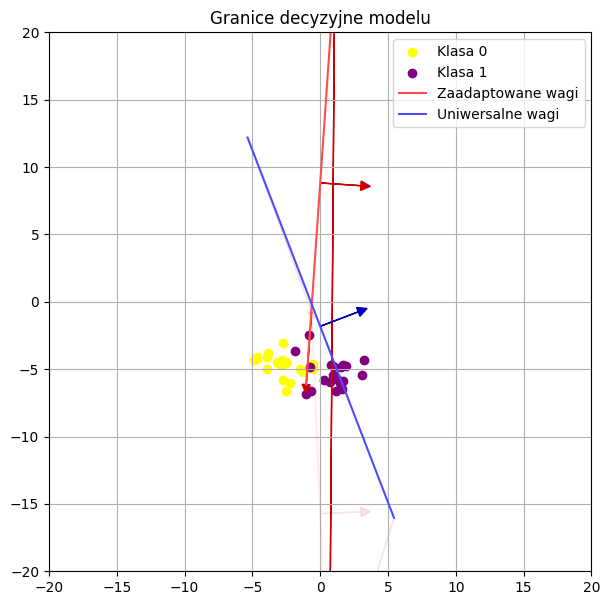

Epoch 1000 | Loss 0.452286 | Acc 91.38% | Task Acc 95.00%


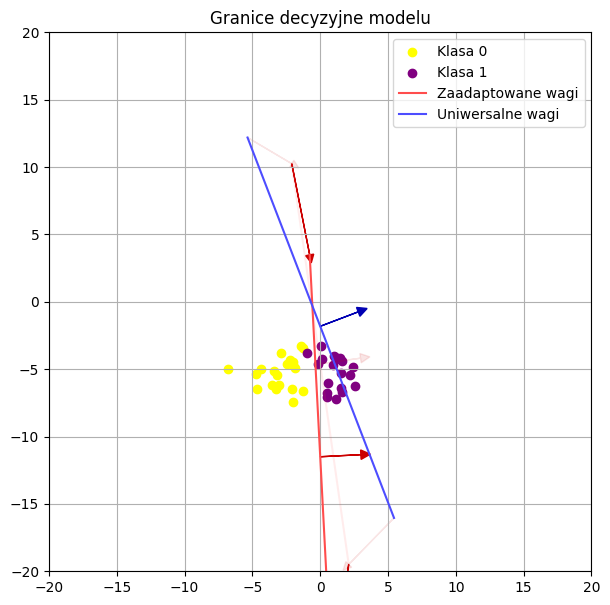

Epoch 1500 | Loss 0.452275 | Acc 91.26% | Task Acc 100.00%


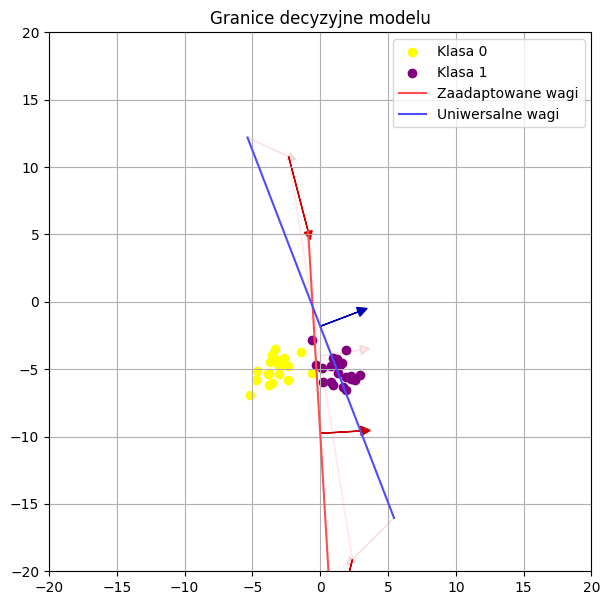

Epoch 2000 | Loss 0.452604 | Acc 91.28% | Task Acc 95.00%


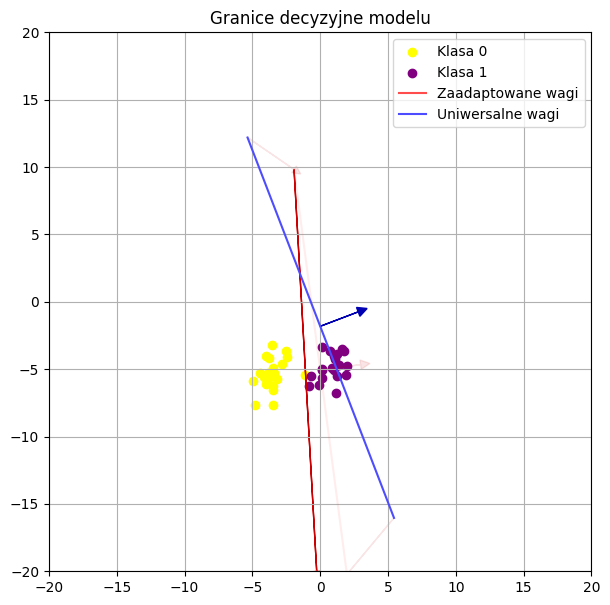

Epoch 2500 | Loss 0.452896 | Acc 91.24% | Task Acc 100.00%


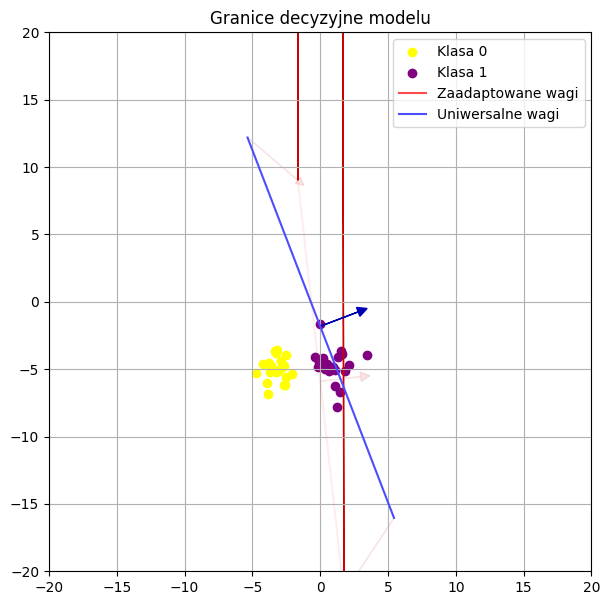

Epoch 3000 | Loss 0.452891 | Acc 91.11% | Task Acc 80.00%


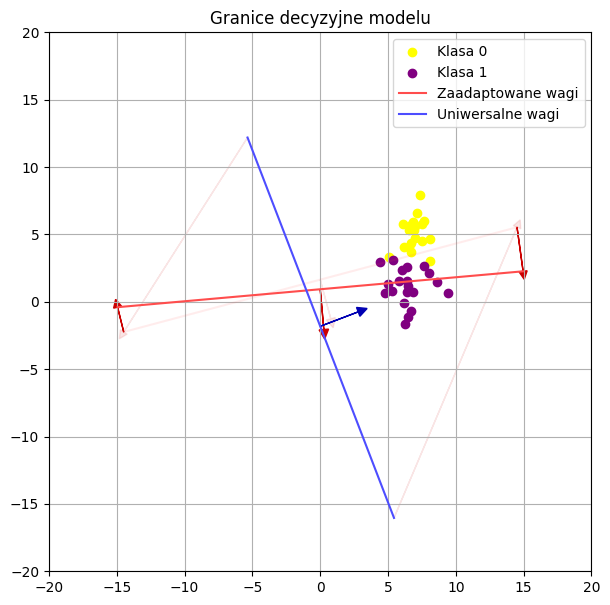

Epoch 3500 | Loss 0.453111 | Acc 91.10% | Task Acc 90.00%


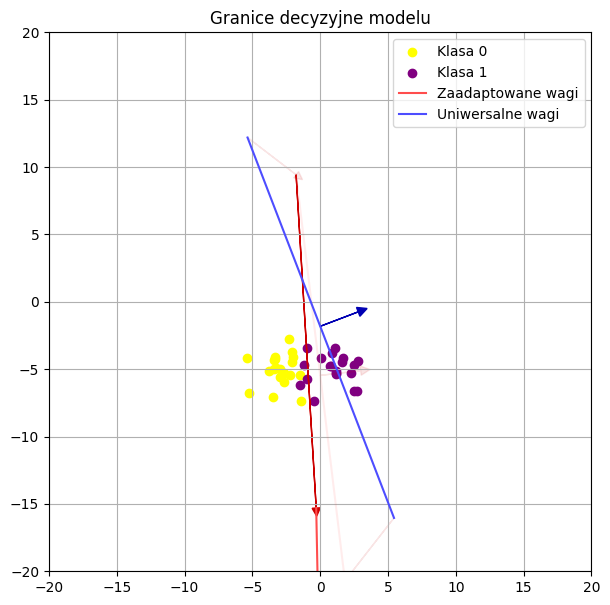

Epoch 4000 | Loss 0.452992 | Acc 91.13% | Task Acc 95.00%


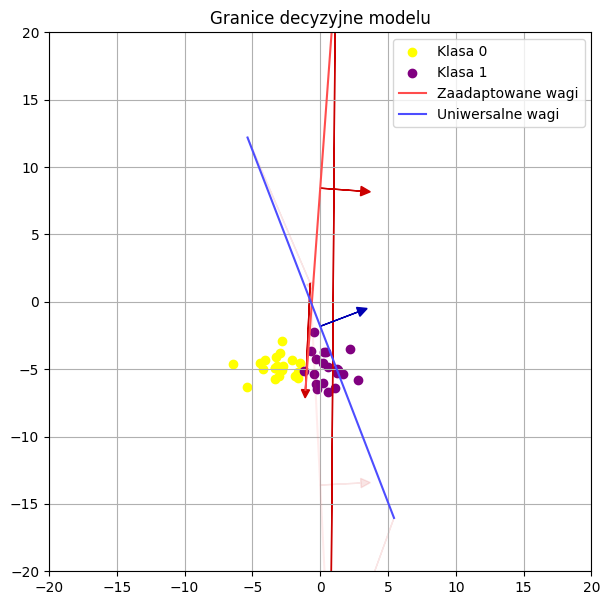

Epoch 4500 | Loss 0.452192 | Acc 91.18% | Task Acc 90.00%


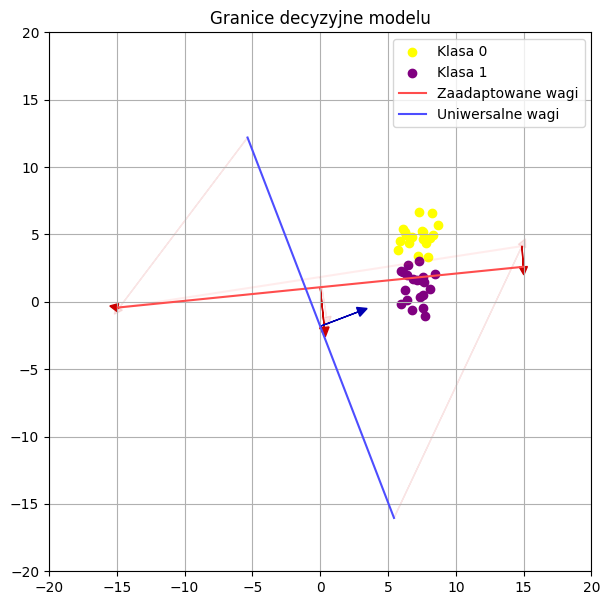

Epoch 5000 | Loss 0.452733 | Acc 91.14% | Task Acc 95.00%


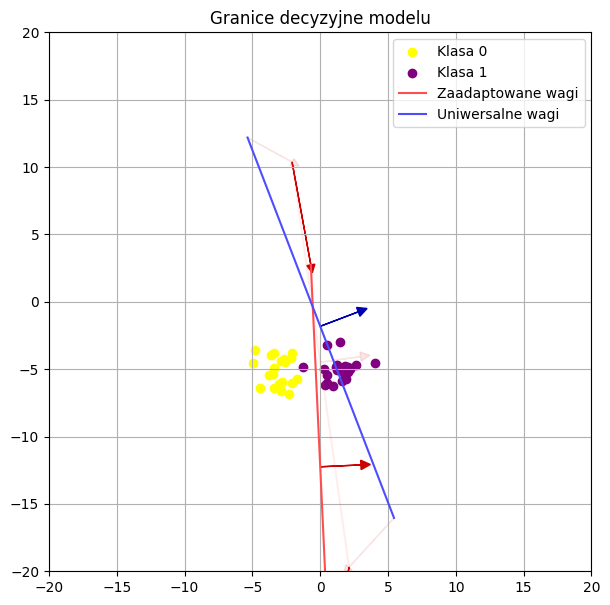

Epoch 5500 | Loss 0.452789 | Acc 91.17% | Task Acc 85.00%


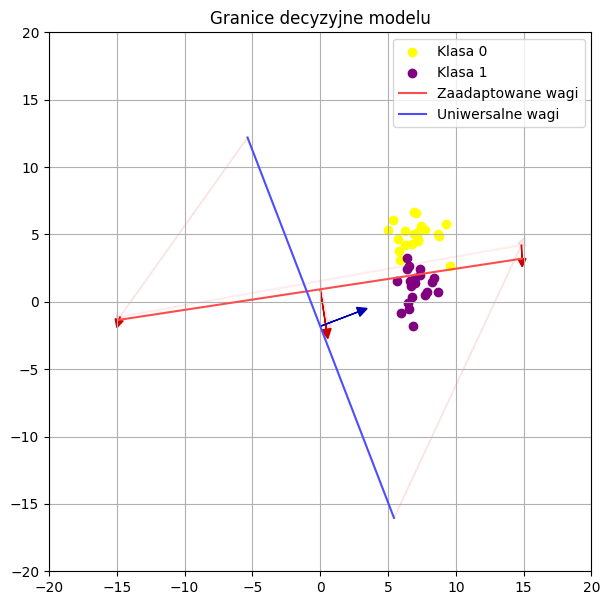

Epoch 6000 | Loss 0.452799 | Acc 91.18% | Task Acc 95.00%


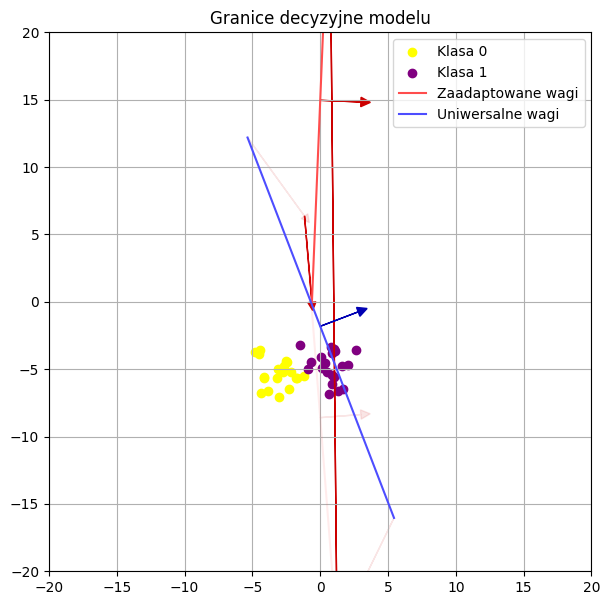

Epoch 6500 | Loss 0.452371 | Acc 91.24% | Task Acc 95.00%


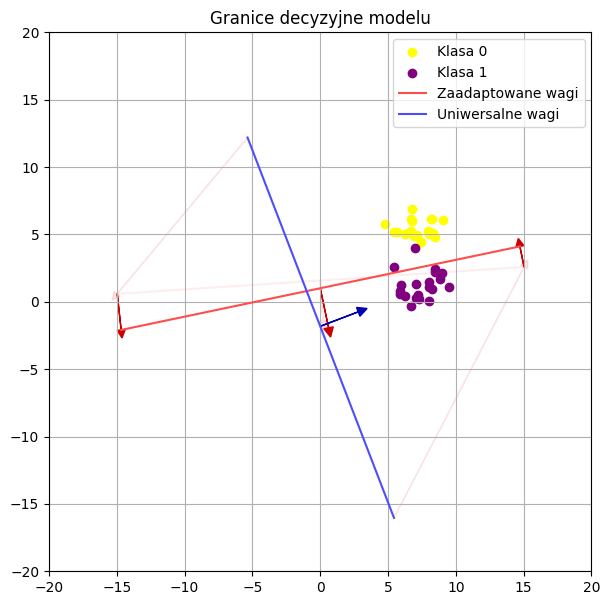

Epoch 7000 | Loss 0.452233 | Acc 91.26% | Task Acc 90.00%


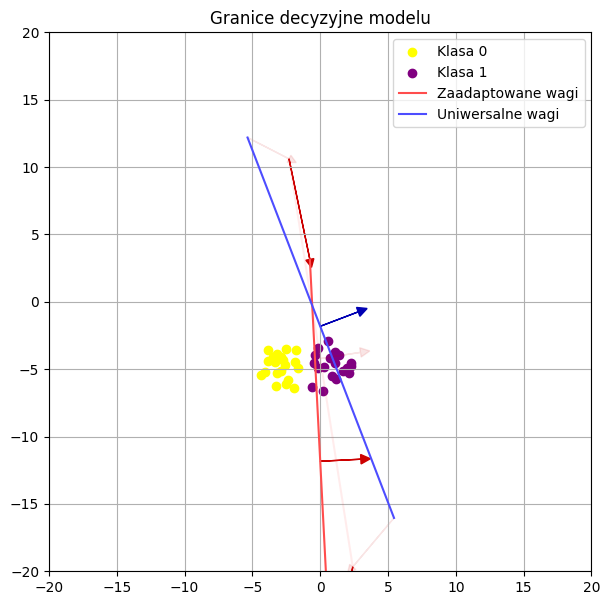

Epoch 7500 | Loss 0.452308 | Acc 91.27% | Task Acc 90.00%


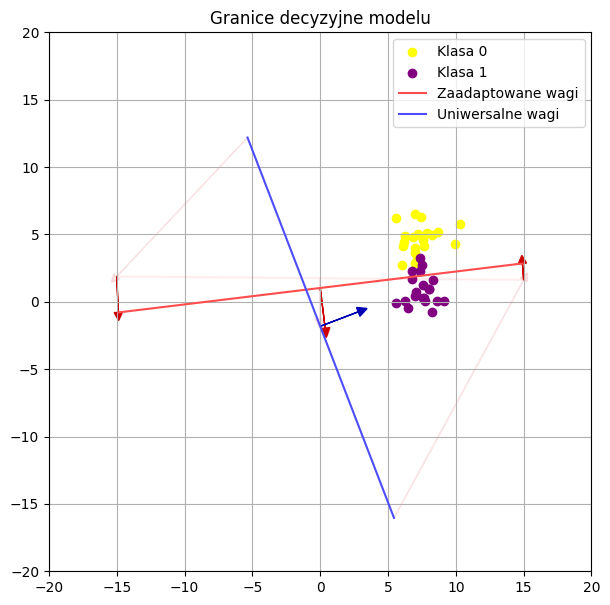

Epoch 8000 | Loss 0.452352 | Acc 91.32% | Task Acc 100.00%


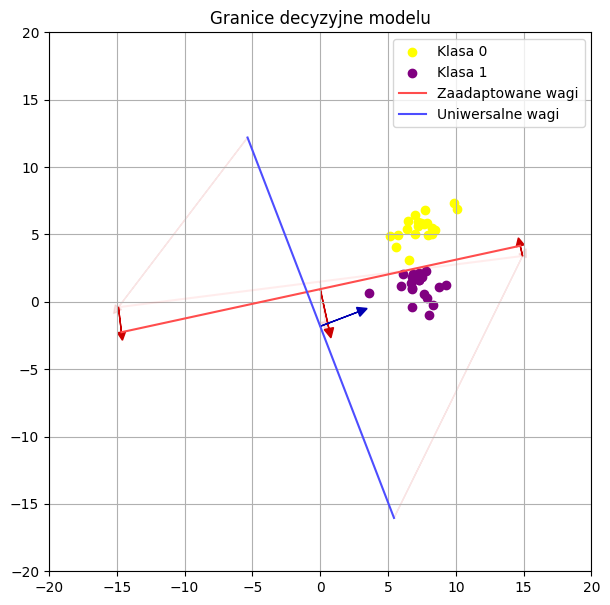

Epoch 8500 | Loss 0.452520 | Acc 91.30% | Task Acc 80.00%


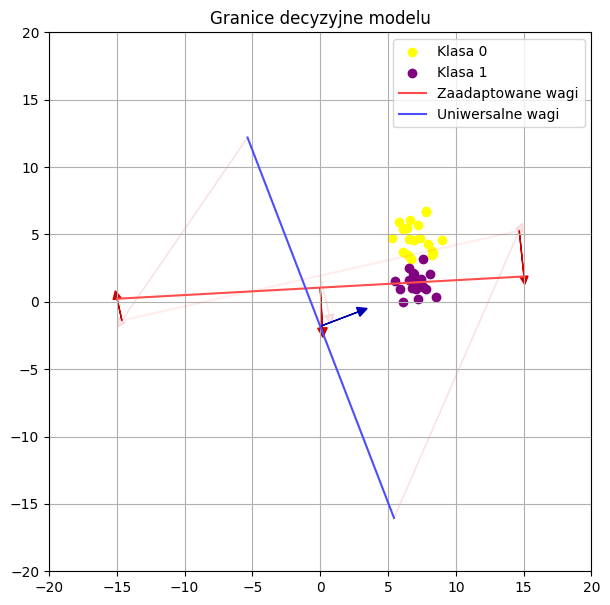

Epoch 9000 | Loss 0.452238 | Acc 91.31% | Task Acc 100.00%


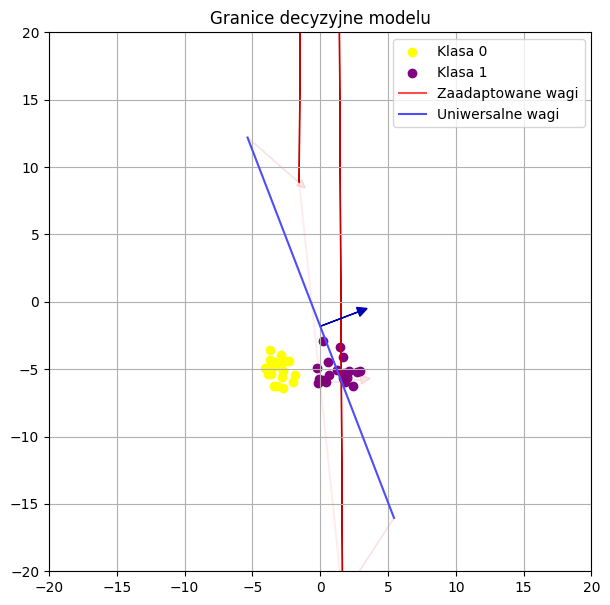

Epoch 9500 | Loss 0.452177 | Acc 91.29% | Task Acc 70.00%


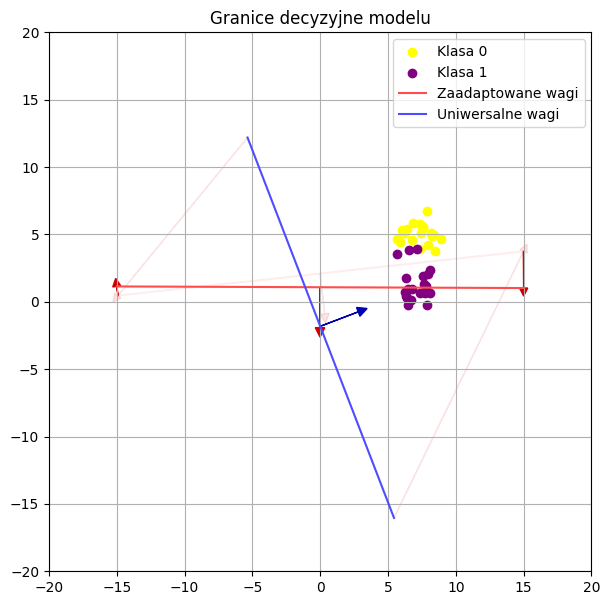

In [14]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# Wszystkie parametry powinny zostać takie same, aby móc porównać działanie z modelem wytrenowanym na wszystkich taskach
epochs = 10000
alpha_lr = 1e-1 # dla kroków gradientowych
beta_lr = 1e-3 # dla wag uniwersalnych modelu
n_gradient_steps = 2 # ile mamy kroków na adaptację do nowego zadania
model_2 = MAML(n_gradient_steps = n_gradient_steps, n_task = 4, alpha_lr = alpha_lr)
optimizer = torch.optim.Adam(model.parameters(), lr=beta_lr) 
train(model_2, epochs, task_functions, optimizer)

Uruchom poniższą komórkę, aby włączyć narzędzie

In [15]:


precomputed_tasks = [task(20) for task in task_functions]

def series(blue_x_mean=0, blue_y_mean=0, blue_x_std=1, blue_y_std=1, pink_x_mean=0, pink_y_mean=0, pink_x_std=1, pink_y_std=1):
    C0 = generate_distribution(blue_x_mean, blue_x_std, blue_y_mean, blue_y_std, n_samples=n_samples)
    C1 = generate_distribution(pink_x_mean, pink_x_std, pink_y_mean, pink_y_std, n_samples=n_samples)

    new_X = torch.cat((C0, C1))
    new_y = torch.cat((torch.zeros(n_samples), torch.ones(n_samples)))
    
    X_support, y_support, X_query, y_query = split_support_query(new_X, new_y)
    model_2.adapt_theta(X_support, y_support, X_query, y_query)
    
    
    plot_maml_boundaries_all_tasks(model_2, precomputed_tasks, (new_X, new_y))
    final_scores = model_2.forward(X_query)
    y_query = y_query.unsqueeze(1)

    predictions  = (final_scores > 0.5)
    correct_predictions = (predictions == y_query)
    task_accuracy = (correct_predictions.sum() / predictions.size()[0]) * 100
    print(f"Accuracy {task_accuracy.item()}%")
    return


interact(series, blue_x_mean=(-10,10,0.1), blue_y_mean=(-10,10,0.1), blue_x_std=(0,10,0.1),blue_y_std=(0,10,0.1), pink_x_mean=(-10,10,0.1), pink_y_mean=(-10,10,0.1), pink_x_std=(0,10,0.1), pink_y_std=(0,10,0.1));

interactive(children=(FloatSlider(value=0.0, description='blue_x_mean', max=10.0, min=-10.0), FloatSlider(valu…

### Wnioski i obserwacje

Tym razem wagi uniwersalne nie separują tak dobrze żadnego z zadań. Granica decyzyjna nie jest też ustawiona idealnie między zadaniami (co sprawiałoby, że dystans do obu z nich będzie taki sam - równie szybka możliwość dostosowania wag). W procesie treningu nie zachodziła prawie żadna zmiana w wagach uniwersalnych. Być może inicjalizacja okazała się tak trafna, że nie było potrzeby modyfikacji, a kroki gradientowe wystarczały do wykonania zadań.

Ponownie, ustawienie próbek w miejscu wcześniej widzianych rozkładów (lub w ich pobliżu) daje świetne rezultaty, czyli model poprawnie się do nich dostoswał.

Jeśli jednak trochę oddalimy się od wcześniej widzianych zadań, uzyskujemy fatalne wyniki. Porównując zachowanie tego i poprzedniego modelu widać sporą różnicę. Ponieważ parametry uczenia były takie same, można wyciągnąć wniosek, że jest to spowodowane mniejszą liczbą zadań, które zostały przedstawione modelowi w czasie treningu. Najwyraźniej nie reprezentują one dostatecznie dobrze rozkładów, które mogłyby się pojawić. Co przyczynia się do braku umiejętności generalizowania naszego modelu.

Możliwe też, że zmiana liczby kroków gradientowych lub epok mogłaby zastąpić zróżnicowany dataset, a przynajmniej zminimalizować straty.



# Podsumowanie

Główna idea MAML to przysposobienie dowolnego modelu o zdolność szybkiego uczenia się nowych zadań. Dzieje się tak, dzięki takim dobraniu wag uniwersalnych (startowych), aby móc z nich w kilku krokach uzyskać wagi rozwiązujące nowe, nie widziane wcześniej zadania.

Możemy kontrolować proces uczenia przy pomocy parametrów szybkości nauczania ($\alpha$ i $\beta$) oraz długości treningu. Istotne jest także dobranie zróżnicowanych zadań, które nie są redundantne i reprezentują szeroki zakres możliwych problemów, tak aby model był w stanie poradzić sobie nawet z ciężkimi przypadkami.

Mamy nadzieję, że teraz pierwsze [ćwiczenie](https://interactive-maml.github.io/) [1], będzie proste zarówno dla Was jak i Waszych modeli.

# Źródła
[1] An Interactive Introduction to Model-Agnostic Meta-Learning: https://interactive-maml.github.io/, (data dostępu: 06.12.2023)

[2] Model Agnostic Meta Learning (MAML) | Machine Learning: https://www.youtube.com/watch?v=ItPEBdD6VMk, (data dostępu: 06.12.2023)

[3] Model-Agnostic Meta-Learning for Fast Adaptation of Deep Networks https://arxiv.org/abs/1703.03400

[4] Google Colab HyperMAML: https://colab.research.google.com/drive/1hqY8rp8aRVm_a7DvIBHH_MHf0c9URQpn?usp=sharing